In [1]:
import os
import sys
import h5py

import pandas as pd
import numpy as np
import panel as pn
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm.notebook import tqdm
from scipy.stats import sem
from datetime import datetime

sys.path.insert(0, r'..\..')
import paths
import functions_bondjango as bd
import functions_kinematic as fk
import functions_plotting as fp
import functions_preprocessing as fpr
import functions_misc as fm
import functions_data_handling as fd
import functions_vscreens as vs


import importlib
importlib.reload(vs)

line_width = 5

In [2]:
def recalculate_2D_target_mouse_distance(exp_traces):

    temp_target_x = exp_traces['target_x'].copy()
    temp_target_y = exp_traces['target_y'].copy()

    print('target y max:', max(temp_target_y), 'target y min:', min(temp_target_y[temp_target_y != -1]))

    mouse_x = exp_traces['mouse_x_m'].copy()
    mouse_y = exp_traces['mouse_y_m'].copy()
    print('mouse y max:', max(mouse_y), 'mouse y min:', min(mouse_y))

    x_diff = [abs(max(mouse_x) - max(temp_target_x)), 
             abs(min(mouse_x) - min(temp_target_x[temp_target_x != -1]))]
    y_diff = [abs(max(mouse_y) - max(temp_target_y)),
              abs(min(mouse_y) - min(temp_target_y[temp_target_y != -1]))]

    print('x offset:', x_diff, 'y offset:', y_diff)

    temp_target_y[(temp_target_y > 0)] -= y_diff[0]
    temp_target_y[(temp_target_y < 0) & (temp_target_y > -1)] += y_diff[1]
    
    print('recalc target y max:', max(temp_target_y), 'recalc target y min:', min(temp_target_y[temp_target_y != -1]), '\n')

    # replace the target y coordinates with the newly calculated ones
    exp_traces['target_y'] = temp_target_y

    mouse_coord = exp_traces.loc[:, ['mouse_x_m', 'mouse_y_m']].to_numpy()
    target_coord = exp_traces.loc[:, ['target_x', 'target_y']].to_numpy()
    target_mouse_distance = fk.distance_calculation(target_coord, mouse_coord)

    exp_traces['target_mouse_distance_recalc'] = target_mouse_distance
    exp_traces['target_mouse_x_distance'] = np.abs(temp_target_x - exp_traces['mouse_x_m'])
    exp_traces['target_mouse_y_distance'] = np.abs(temp_target_y - exp_traces['mouse_y_m']) 

    return exp_traces   

In [3]:
def recalculate_3D_target_mouse_distance(exp_traces):

    mouse_coord = exp_traces.loc[:, ['mouse_x_m', 'mouse_y_m']].to_numpy()
    target_coord = exp_traces.loc[:, ['target_x', 'target_y']].to_numpy()
    target_mouse_distance = fk.distance_calculation(target_coord, mouse_coord)

    exp_traces['target_mouse_distance_recalc'] = target_mouse_distance

    return exp_traces   

In [4]:
def thresh_function(param, thres):
    return param <= thres

In [5]:
def flatten_list(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

In [6]:
# define the name to be used for the saved figures
dimensionality = '2D'
save_name = 'VScreen_' + dimensionality + '_old'

In [6]:
# If this data set was already processed
trial_approaches = pd.read_hdf(r"D:/vscreens/" + save_name, 'data')

In [7]:
search_params = {'result': 'test',
                 'lighting': 'normal',
                 'rig': 'VScreen',
                 'analysis_type': 'preprocessing',
                 'ltdate': '2021-03-22T00-00-00',
                 'notes': dimensionality
                }

search_string = ', '.join("{}:{}".format(key,val) for (key,val) in search_params.items())
data = vs.load_VScreens_datasets(search_string, exclusion="removedtracker")

J:\Drago Guggiana Nilo\Prey_capture\AnalyzedData\11_12_2020_15_40_54_VScreen_DG_200526_d_test_2D_preproc.hdf5
2020-11-12
J:\Drago Guggiana Nilo\Prey_capture\AnalyzedData\11_12_2020_13_31_20_VScreen_DG_200526_c_test_2D_preproc.hdf5
2020-11-12
J:\Drago Guggiana Nilo\Prey_capture\AnalyzedData\11_12_2020_11_55_22_VScreen_DG_200526_b_test_2D_preproc.hdf5
2020-11-12
J:\Drago Guggiana Nilo\Prey_capture\AnalyzedData\11_12_2020_10_29_00_VScreen_DG_200526_a_test_2D_preproc.hdf5
2020-11-12
J:\Drago Guggiana Nilo\Prey_capture\AnalyzedData\11_11_2020_14_30_08_VScreen_DG_200526_d_test_2D_preproc.hdf5
2020-11-11
J:\Drago Guggiana Nilo\Prey_capture\AnalyzedData\11_11_2020_13_02_29_VScreen_DG_200526_c_test_2D_preproc.hdf5
2020-11-11
J:\Drago Guggiana Nilo\Prey_capture\AnalyzedData\11_11_2020_11_36_46_VScreen_DG_200526_b_test_2D_preproc.hdf5
2020-11-11
J:\Drago Guggiana Nilo\Prey_capture\AnalyzedData\11_11_2020_10_13_02_VScreen_DG_200526_a_test_2D_preproc.hdf5
2020-11-11
J:\Drago Guggiana Nilo\Prey_capt

In [8]:
exp_manipulation_params = ['color_target', 'scale', 'speed']
df_columns = ['date', 'animal', 'bin', 'trial_num', 'target_color', 'speed', 'scale', 'approaches', 'has_approach']

# encounter_criteria
approach_criteria = {a'2D': {'distance_threshold':0.05, 'speed_minimum': 0.10, 'start_distance': 0.05, 'window': 2},
                     '3D': {'distance_threshold':0.10, 'speed_minimum': 0.10, 'start_distance': 0.05, 'window': 2}
                     }

In [9]:
# For later visualization
all_valid_approaches = []
all_approaches = []
bin_duration = 10    # minutes

test_ds = data[3:4]

# Get the relevant criteria
crit = approach_criteria[dimensionality]

# Make a new data frame
approach_df = pd.DataFrame(columns=df_columns)

for exp_num, exp in tqdm(enumerate(test_ds), total=len(test_ds)):

    # Calculate time bins for each data point in the experiment
    exp['traces']['bin'] = vs.calculate_bins(exp['traces']['time_vector'], bin_duration)

    # In the 2D case, the targets are outside the boundaries of the arena
    if dimensionality == '2D':
        exp['traces'] = recalculate_2D_target_mouse_distance(exp['traces'])
    else:
        exp['traces'] = recalculate_3D_target_mouse_distance(exp['traces'])

    # Calculate the distance travelled between each time point in the experiment
    exp['traces']['distance_travelled'] = fk.accumulated_distance(exp['traces'][['mouse_x_m', 'mouse_y_m']].to_numpy())
        
#     # Extract the approaches in this experiment
#     experiment_approaches = pd.DataFrame(columns=df_columns)
#     experiment_approaches, exp_valid_approaches, all_exp_approaches = vs.extract_experiment_approaches(exp, 
#                                                                                                   exp_manipulation_params, 
#                                                                                                   crit, 
#                                                                                                   thresh_function,
#                                                                                                   experiment_approaches
#                                                                                                  )
    
#     approach_df = approach_df.append(experiment_approaches, ignore_index=True)
#     all_valid_approaches.append(exp_valid_approaches)
#     all_approaches.append(all_exp_approaches)
                             
        
# approach_df.to_hdf(r"D:/vscreens/" + save_name, 'data')

target y max: 0.2720683 target y min: -0.393636
mouse y max: 0.2742178 mouse y min: -0.4113157
x offset: [0.07557810000000009, 0.4142219] y offset: [0.0021495000000000264, 0.01767970000000002]
recalc target y max: 0.26991879999999996 recalc target y min: -0.37595629999999997 




In [15]:
exp['traces'].groupby(['bin'])['distance_travelled'].sum()

bin
0.0    66.182948
1.0    60.300964
2.0    62.629922
3.0    57.230613
4.0    61.717516
5.0    60.954661
6.0    60.690798
7.0    20.141846
Name: distance_travelled, dtype: float64

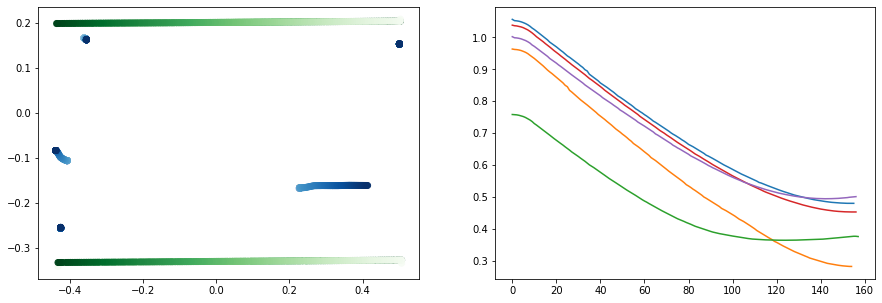

In [12]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
for trial_idx, a in parameter_traces.iterrows():
    row = pd.DataFrame(a).T
    row = row.apply(pd.Series.explode)

    ax[0].scatter(row['mouse_x'], row['mouse_y'], c=row['time_vector'], cmap='Blues')
    ax[0].scatter(row['target_x'], row['target_y'], c=row['time_vector'], cmap='Greens')
    ax[1].plot(range(len(row)), row['target_mouse_distance_recalc'])

In [81]:
import ipywidgets as widgets

def plot_approach_params(data, criteria, idx=0):
    df = data[idx][0]
    trace = data[idx][1]
    features = data[idx][2]

    fig = plt.figure(figsize=(15,8))
    gs = GridSpec(8, 6, figure=fig)

    ax1 = fig.add_subplot(gs[:2, :2])
    ax1.plot(df['time_vector'], df['target_mouse_distance_recalc']*100)
    ax1.axhline(int(criteria['dist_thresh']*100), color='r')
    ax1.axvline(2, color='gray')
    ax1.set_ylabel('Mouse target dist \n (cm)')

    ax2 = fig.add_subplot(gs[2:4, :2])
    ax2.plot(df['time_vector'], df['mouse_speed']*100)
    ax2.axhline(int(criteria['speed_cutoff']*100), color='r')
    ax2.set_ylabel('Mouse speed \n (cm/s)')

    ax3 = fig.add_subplot(gs[4:6, :2])
    ax3.plot(df['time_vector'], df['target_delta_heading'])
    # ax3.plot(np.diff(df[idx]['target_delta_heading']))
    ax3.set_ylim([-180, 180])
    ax3.set_ylabel('Target $\Delta$ heading \n (deg)')

    ax4 = fig.add_subplot(gs[6:, :2])
    ax4.plot(df['time_vector'], df['target_delta_head'])
    # ax4.plot(np.diff(df[idx]['target_delta_head']))
    ax4.set_ylim([-180, 180])
    ax4.set_ylabel('Target $\Delta$ head \n (deg)')
    ax4.set_xlabel('Time (s)')

    ax5 = fig.add_subplot(gs[2:6, 2:-1])
    ax5.scatter(trace['target_x'], trace['target_y'], marker='.', c='green', alpha=0.005)
    ax5.scatter(trace['mouse_x'], trace['mouse_y'], marker='.', c='b', alpha=0.01)
    p_tar = ax5.scatter(df['target_x'], df['target_y'], c=df['time_vector'], cmap='RdYlGn')
    p_mouse = ax5.scatter(df['mouse_x'], df['mouse_y'], c=df['time_vector'], cmap='RdYlBu')
    ax5.set_ylim([-0.35, 0.35])
    ax5.set_xlim([-0.65, 0.65])
    ax5.invert_xaxis()
    ax5.yaxis.tick_right()
    ax5.set_title("Color {}, Speed {} cm/s, Size {} cm \n [final mouse-target dist: {} cm, mean speed: {} cm/s, start distance: {} cm]".format(*features, int(crit['dist_thresh']*100), int(crit['speed_cutoff']*100), int(crit['start_distance_cutoff']*100)))

    ax6 = fig.add_subplot(gs[1:4, -1])  
    ax6.axis("off") 
    cba = plt.colorbar(p_tar, ax=ax6)
    cba.set_label('Target') 

    ax7 = fig.add_subplot(gs[4:-1, -1])    
    ax7.axis("off")
    cbb = plt.colorbar(p_mouse, ax=ax7)
    cbb.set_label('Mouse')

    plt.tight_layout()


In [151]:
ds_to_plot = all_valid_approaches
widgets.interact(plot_approach_params, data=widgets.fixed(ds_to_plot), criteria=widgets.fixed(crit), idx=(0, len(ds_to_plot) - 1))

interactive(children=(IntSlider(value=0, description='idx', max=69), Output()), _dom_classes=('widget-interact…

<function __main__.plot_approach_params(data, criteria, idx=0)>

In [225]:
ds_to_plot = all_approaches
widgets.interact(plot_approach_params, data=widgets.fixed(ds_to_plot), idx=(0, len(ds_to_plot) - 1))

interactive(children=(IntSlider(value=0, description='idx', max=347), Output()), _dom_classes=('widget-interac…

<function __main__.plot_approach_params(data, idx=0)>

In [12]:
def get_count_mean_sem(df: pd.DataFrame, grouping_params: list, target_param: str) -> pd.DataFrame:
    grouped = df.groupby(['date', *grouping_params])[target_param]
    count = grouped.sum().reset_index()
    mean = count.groupby([*grouping_params])[target_param].mean().unstack().T
    sem = count.groupby([*grouping_params])[target_param].sem().unstack().T

    return count, mean, sem

In [13]:
def get_percentage_trials(df: pd.DataFrame, grouping_params: list, target_param: str) -> pd.DataFrame:
    new_col_name = 'percent_{}'.format(target_param)

    grouped = df.groupby(['date', *grouping_params])[target_param]
    
    percent = 100 * grouped.sum() / grouped.count()
    percent = percent.reset_index()
    percent = percent.rename(columns={target_param: new_col_name})
    
    mean_percent = percent.groupby([*grouping_params])[new_col_name].mean().unstack().T
    sem_percent = percent.groupby([*grouping_params])[new_col_name].sem().unstack().T


    return percent, mean_percent, sem_percent

In [21]:
def percentage_approach_plot(mean: pd.DataFrame, sem: pd.DataFrame, all_trials: pd.DataFrame, grouping_params: list, target_param: str, fig=None):
    
    if fig is None:
        fig, ax = plt.subplots(figsize=(10,8))

    bar_width = 0.35
    labels = ['black', 'gray']

    counts = approach_df.groupby(grouping_params)[target_param].sum().unstack().T
    total = approach_df.groupby(grouping_params)[target_param].count().unstack().T

    for i, col in enumerate(mean.columns):
        x_labels = [int(label) for label in mean.index.to_list()]
        x = np.arange(len(x_labels))

        means = mean[col].to_list()
        sems = sem[col].to_list()
        count = counts[col].to_list()
        tot = total[col].to_list()

        rects = ax.bar(x + i*bar_width, means, bar_width, label=labels[i], color=col, edgecolor=(1, 1, 1), yerr=sems, ecolor=(0.5, 0.5, 0.5))

        for j, rect in enumerate(rects):
            height = rect.get_height()
            ax.annotate('{:.0f}/{:.0f}'.format(count[j], tot[j]),
                        xy=(rect.get_x() + rect.get_width() / 2, height + sems[j]),
                        xytext=(0, 15),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    ax.set_xlabel(target_param)
    ax.set_ylabel('% Trials with Approach')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.set_ylim([0, 100])
    ax.legend()

    return fig

In [15]:
def count_approach_plot(all_trials: pd.DataFrame, mean: pd.DataFrame, sem: pd.DataFrame, fig=None):
    
    if fig is None:
        fig = plt.figure(figsize=(10,8))

    for col in mean.columns:
        x_labels = mean.index.to_list()

        means = mean[col].to_list()
        sems = sem[col].to_list()

        plt.errorbar(x_labels, means, yerr=sems, c=str(col[0]*3), linewidth=5, elinewidth=3)

    plt.ylabel('no. approaches')

    return fig

In [16]:
def rand_jitter(arr):
    stdev = .005 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev  

def plot_scatter_points(data: pd.DataFrame, target_param:str, value:str, fig=None):
    if fig is None:
        fig = plt.figure(figsize=(10,8))

    plt.scatter(rand_jitter(data[target_param]), rand_jitter(data[value]), s=60, c=[(t[0]*3, t[1]*3, t[2]*3, 1) for t in data['target_color']], linewidths=1, edgecolors='k')

    return fig

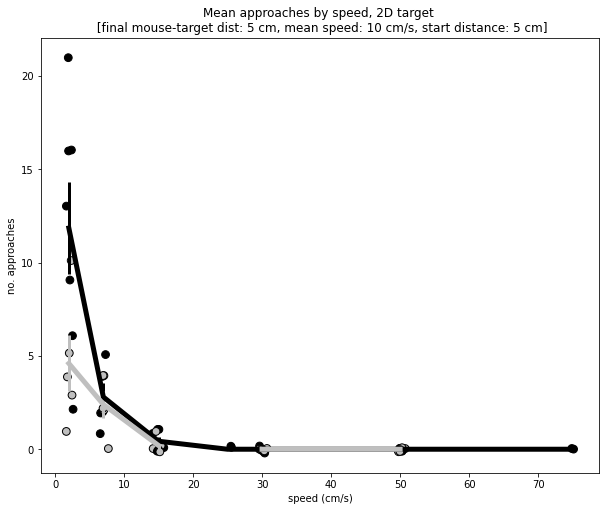

In [19]:
%matplotlib inline
speed_group, speed_mean, speed_sem = get_count_mean_sem(approach_df, ['target_color', 'speed'], 'approaches')

fig = plot_scatter_points(speed_group, 'speed', 'approaches')
fig = count_approach_plot(approach_df, speed_mean, speed_sem, fig=fig)
plt.xlabel('speed (cm/s)')
plt.title('Mean approaches by speed, {} target \n [final mouse-target dist: {} cm, mean speed: {} cm/s, start distance: {} cm]'.format(dimensionality, int(crit['distance_threshold']*100), int(crit['speed_minimum']*100), int(crit['start_distance']*100)))

save_path = os.path.join(paths.figures_path, '_'.join([save_name, 'speed_encounters', str(int(crit['distance_threshold']*100)), str(int(crit['speed_minimum']*100)), str(int(crit['start_distance']*100))]))
plt.savefig(save_path)

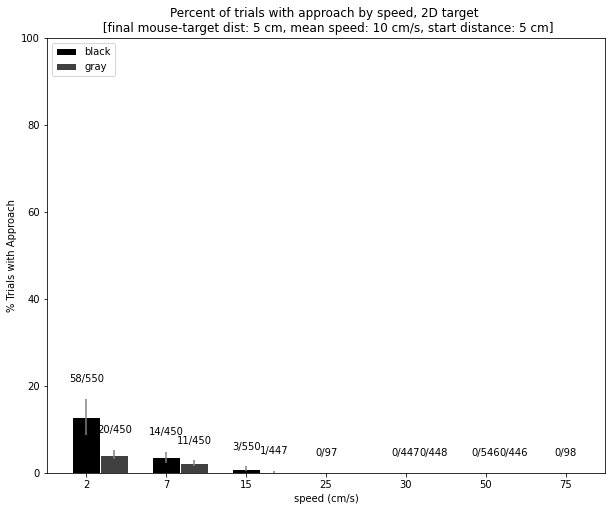

In [22]:
percent_speed_approach, percent_speed_mean, percent_speed_sem = get_percentage_trials(approach_df, ['target_color', 'speed'], 'has_approach')

fig = percentage_approach_plot(percent_speed_mean, percent_speed_sem, approach_df, ['target_color', 'speed'], 'has_approach')
plt.title('Percent of trials with approach by speed, {} target \n [final mouse-target dist: {} cm, mean speed: {} cm/s, start distance: {} cm]'.format(dimensionality, int(crit['distance_threshold']*100), int(crit['speed_minimum']*100), int(crit['start_distance']*100)))
plt.xlabel('speed (cm/s)')

save_path = os.path.join(paths.figures_path, '_'.join([save_name, 'speed_percent_engagement', str(int(crit['distance_threshold']*100)), str(int(crit['speed_minimum']*100)), str(int(crit['start_distance']*100))]))
plt.savefig(save_path)

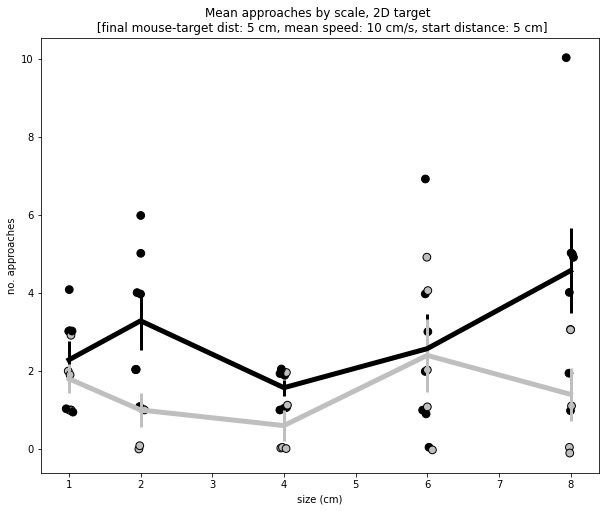

In [23]:
scale_group, scale_mean, scale_sem = get_count_mean_sem(approach_df, ['target_color', 'scale'], 'approaches')

fig = plot_scatter_points(scale_group, 'scale', 'approaches')
fig = count_approach_plot(approach_df, scale_mean, scale_sem, fig=fig)
plt.xlabel('size (cm)')
plt.title('Mean approaches by scale, {} target \n [final mouse-target dist: {} cm, mean speed: {} cm/s, start distance: {} cm]'.format(dimensionality, int(crit['distance_threshold']*100), int(crit['speed_minimum']*100), int(crit['start_distance']*100)))

save_path = os.path.join(paths.figures_path, '_'.join([save_name, 'scale_encounters', str(int(crit['distance_threshold']*100)), str(int(crit['speed_minimum']*100)), str(int(crit['start_distance']*100))]))
plt.savefig(save_path)

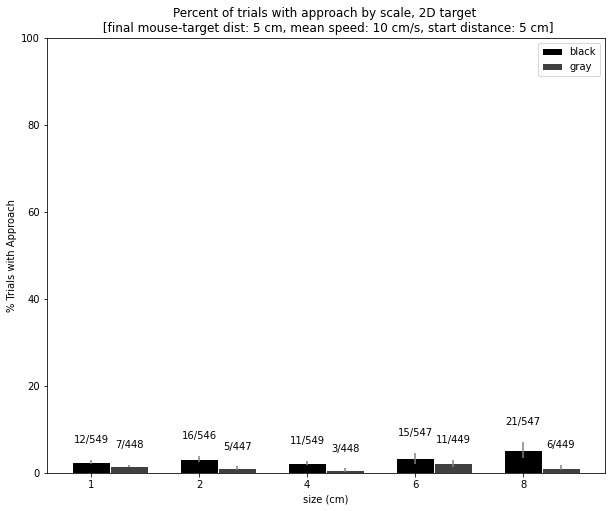

In [24]:
percent_scale_approach, percent_scale_mean, percent_scale_sem = get_percentage_trials(approach_df, ['target_color', 'scale'], 'has_approach')

percentage_approach_plot(percent_scale_mean, percent_scale_sem, approach_df, ['target_color', 'scale'], 'has_approach')
plt.xlabel('size (cm)')
plt.title('Percent of trials with approach by scale, {} target \n [final mouse-target dist: {} cm, mean speed: {} cm/s, start distance: {} cm]'.format(dimensionality, int(crit['distance_threshold']*100), int(crit['speed_minimum']*100), int(crit['start_distance']*100)))

save_path = os.path.join(paths.figures_path, '_'.join([save_name, 'scale_percent_engagement', str(int(crit['distance_threshold']*100)), str(int(crit['speed_minimum']*100)), str(int(crit['start_distance']*100))]))
plt.savefig(save_path)

In [26]:
from matplotlib import ticker

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.
    
    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) < threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

def plot_heatmap(values, xlabels, ylabels, ax=None, **kwargs):

    if ax is None:
        fig, ax = plt.subplots()

    cmap_min = kwargs.get('cmap_min', 0)
    cmap_max = kwargs.get('cmap_max', np.max(values))
        
    im = ax.imshow(values, cmap='viridis', vmin=cmap_min, vmax=cmap_max)
    _ = annotate_heatmap(im, valfmt="{x:.2f}")

    ax.set_xticks(np.arange(len(xlabels)))
    ax.set_xticklabels(xlabels)
    ax.set_yticks(np.arange(len(ylabels)))
    ax.set_yticklabels(ylabels)
    ax.invert_yaxis()

    return im, ax

In [27]:
def plot_approach_heatmaps_by_contrast(df, level=0, fig=None, axes=None, **kwargs):
    colors = df.groupby(level=[level]).agg(list).index.to_list()
    color_labels = {'(0, 0, 0, 1)': '100% black',
                    '(0.25, 0.25, 0.25, 1)': '75% gray',
    }

    if axes is None:
        fig, axes = plt.subplots(2, 1, figsize=(10, 20), constrained_layout=True)

    images = []
    cmap_max = kwargs.get('cmap_max', None)
    
    for i, color in enumerate(colors):
        ax = axes[i]
        data = df.xs(color, level=level)
        values = data.values
        speeds = [int(a) for a in data.index.to_list()]
        scales = data.columns.to_list()
        
        im, ax = plot_heatmap(values, scales, speeds, ax=ax, **kwargs)
        images.append(im)
        
        if cmap_max is None:
            cmap_max = np.max(values)
            kwargs['cmap_max'] = cmap_max
        
        
        axes[i].set_ylabel('Speeds [cm/s]')
        axes[i].set_xlabel("Scale [cm]")
        if 'date' in kwargs:
            axes[i].set_title('{}\nColor: {}'.format(kwargs.get('date'), color_labels[str(color)]))
        elif 'nbin' in kwargs:
            axes[i].set_title('Bin: {}\nColor: {}'.format(str(int(kwargs.get('nbin'))), color_labels[str(color)]))
        else:
            axes[i].set_title('Color: {}'.format(color_labels[str(color)]))
        
    if i+1 <= len(axes):
        for ax in axes[i+1:]:
            ax.set_visible(False)

    return fig, axes, images, cmap_max

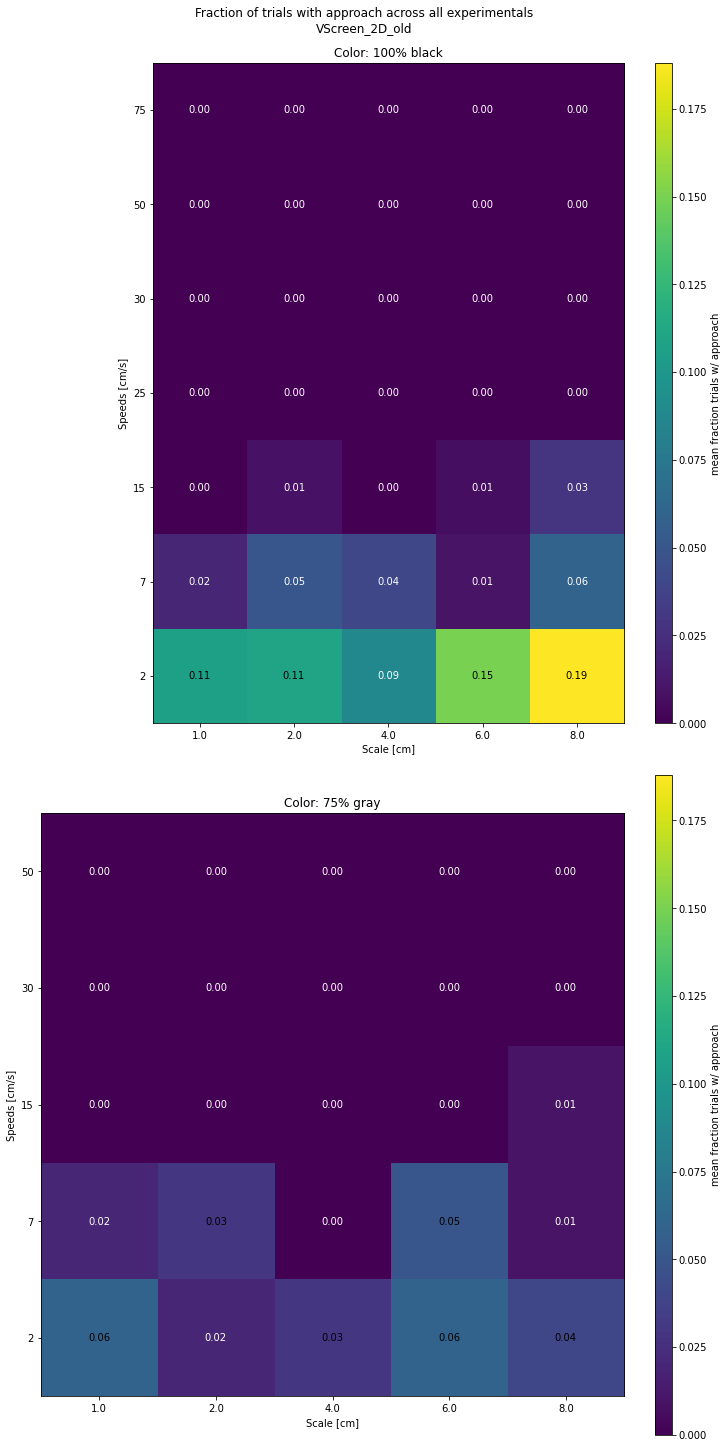

In [28]:
%matplotlib inline
group_params = ['target_color', 'speed', 'scale']
target_param = 'has_approach'

percent_approach, percent_mean, percent_sem = get_percentage_trials(approach_df, group_params, target_param)
num_approach, num_mean, num_sem = get_count_mean_sem(approach_df, group_params, target_param)

fig, axes, ims, _ = plot_approach_heatmaps_by_contrast(percent_mean.T/100)

cbar_im = ims[0] 
for ax in axes:
    fig.colorbar(cbar_im, ax=ax, label='mean fraction trials w/ approach', fraction=0.04, pad=0.04)
    
plt.suptitle('Fraction of trials with approach across all experimentals\n{}'.format(save_name))

save_path = os.path.join(paths.figures_path, '_'.join([save_name, 'heatmap_frac_approach']))
plt.savefig(save_path)

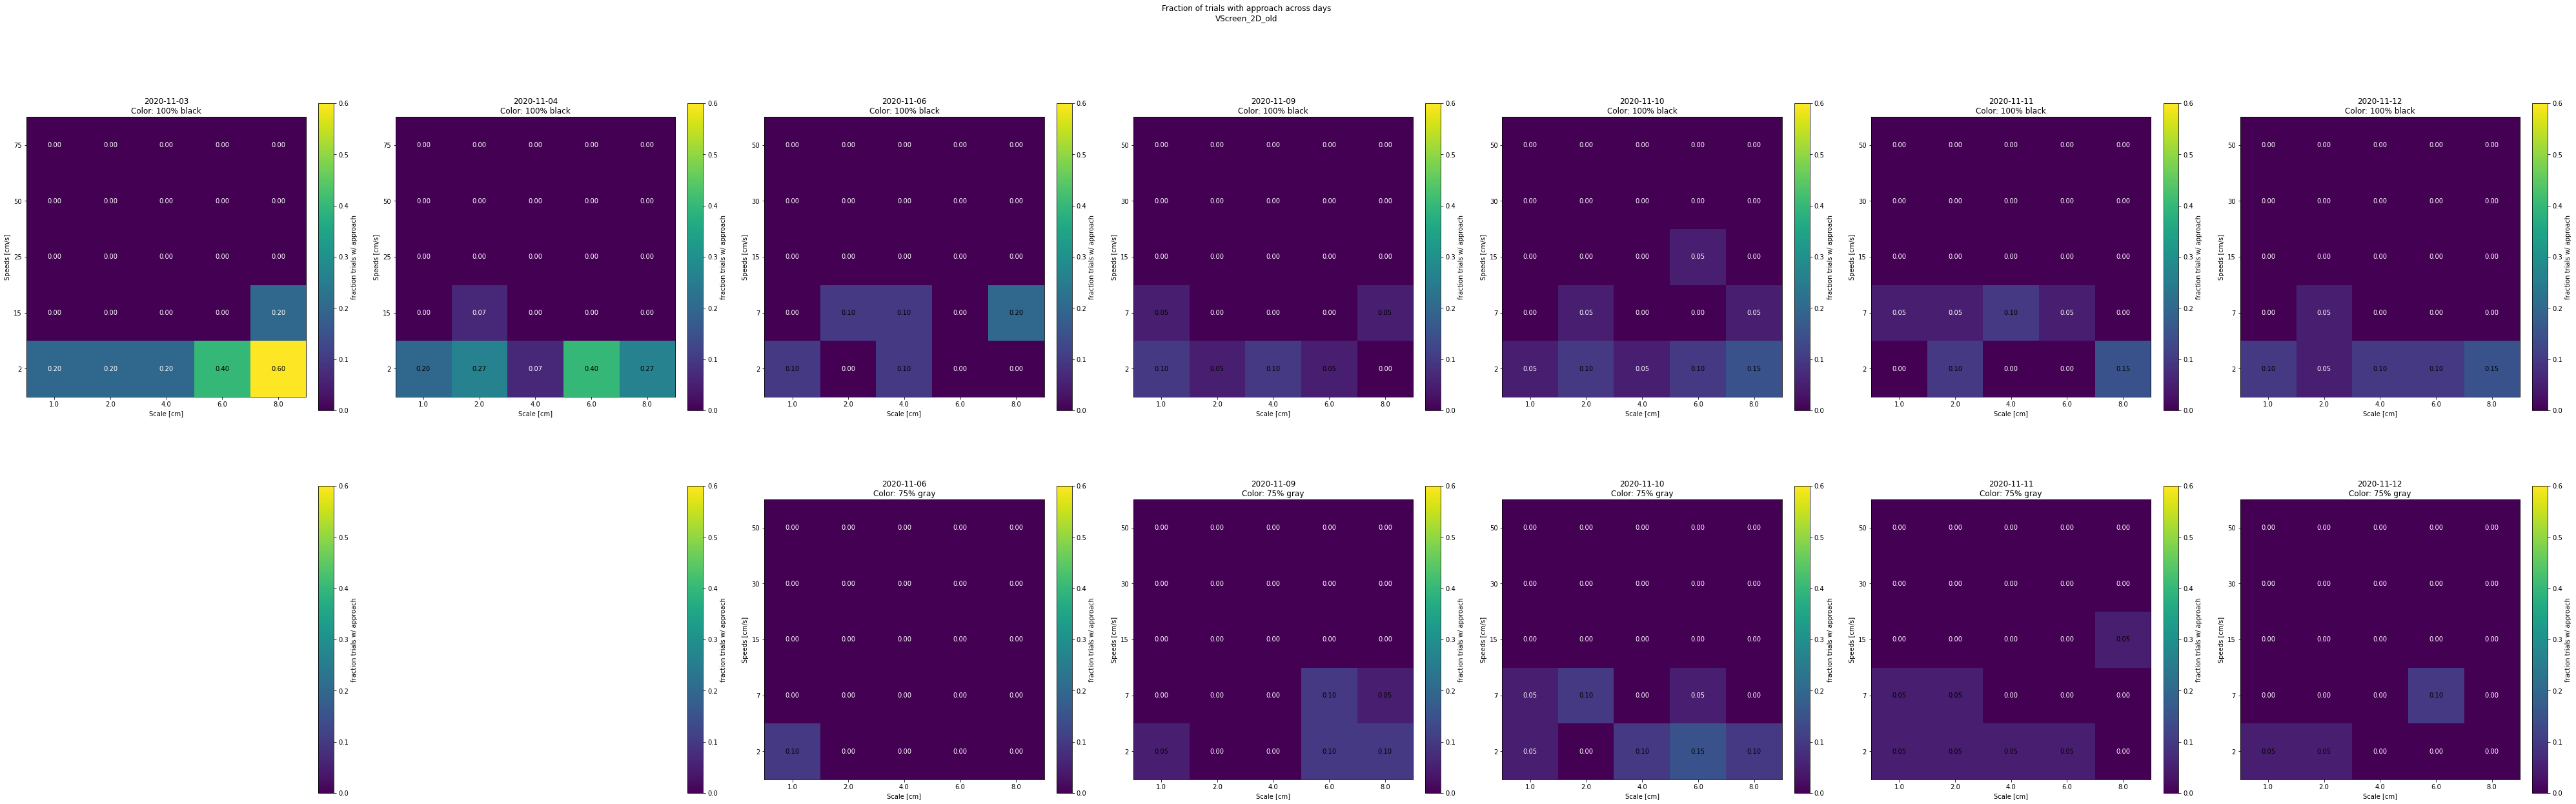

In [29]:
group_params = ['date', 'target_color', 'speed', 'scale']
target_param = 'has_approach'

grouped = approach_df.groupby(group_params)[target_param].sum() / approach_df.groupby(group_params)[target_param].count()

cols = len(list(grouped.groupby(['date']).groups.keys()))
rows = len(list(grouped.groupby(['target_color']).groups.keys()))

fig = plt.figure(figsize=(10*cols, 10*rows))
gs = GridSpec(rows, cols, figure=fig)

images = []
cmap_max = None
for col, (date, d) in enumerate(grouped.unstack().groupby(['date'])):
    sub_axes = []
    for r in range(rows):
        sub_axes.append(fig.add_subplot(gs[r, col]))
    
    d = d.reset_index(level=0, drop=True)
    _, axes, ims, cmap_max_first_subplot = plot_approach_heatmaps_by_contrast(d, fig=fig, axes=sub_axes, cmap_max=cmap_max, date=date)
    images.append(ims)
    
    if cmap_max is None:
        cmap_max = cmap_max_first_subplot
 
cbar_im = images[0][0]
for ax in fig.get_axes():
    fig.colorbar(cbar_im, ax=ax, label='fraction trials w/ approach', fraction=0.05, pad=0.04)
 
plt.suptitle('Fraction of trials with approach across days\n{}'.format(save_name))

save_path = os.path.join(paths.figures_path, '_'.join([save_name, 'heatmap_frac_approach_days']))
plt.savefig(save_path)

<string>:6: UserWarning: Warning: converting a masked element to nan.
C:\Users\mmccann\Miniconda3\envs\prey_capture\lib\site-packages\numpy\core\_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


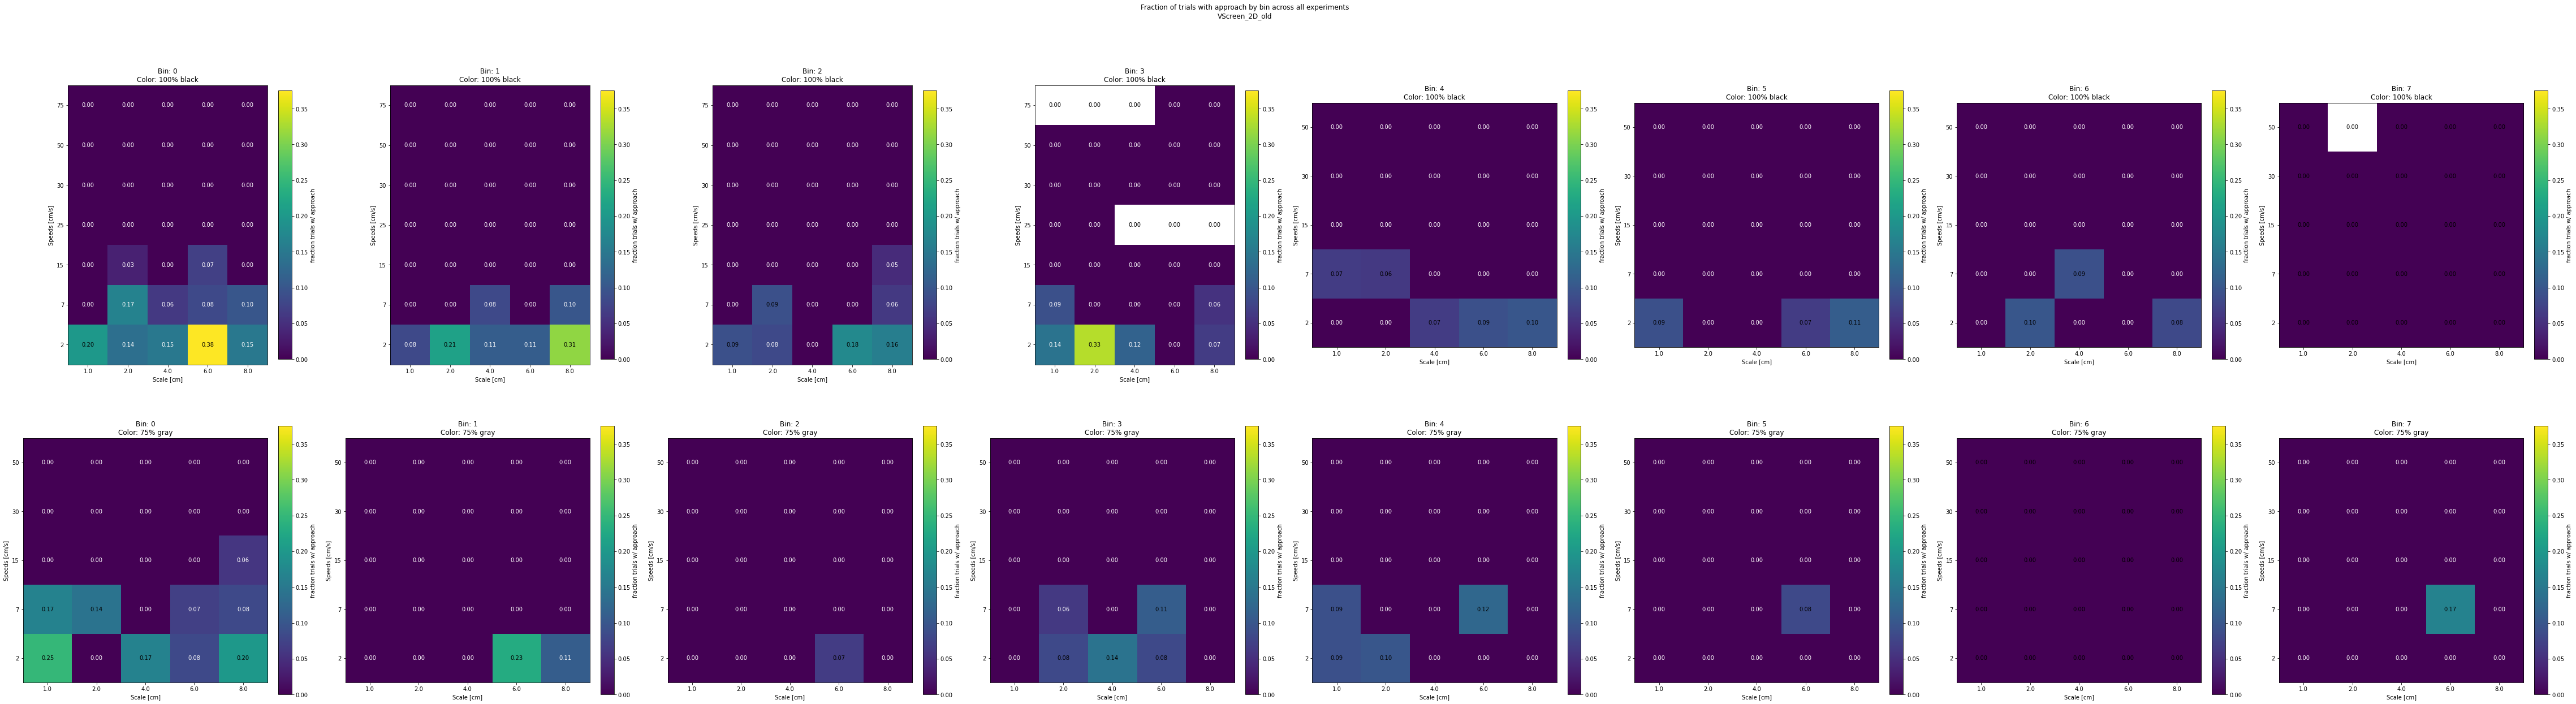

In [30]:
group_params = ['bin', 'target_color', 'speed', 'scale']
target_param = 'has_approach'

grouped = approach_df.groupby(group_params)[target_param].sum() / approach_df.groupby(group_params)[target_param].count()

cols = len(list(grouped.groupby(['bin']).groups.keys()))
rows = len(list(grouped.groupby(['target_color']).groups.keys()))

fig = plt.figure(figsize=(10*cols, 10*rows))
gs = GridSpec(rows, cols, figure=fig)

images = []
cmap_max = None

for col, (bins, b) in enumerate(grouped.unstack().groupby(['bin'])):
    sub_axes = []
    for r in range(rows):
        sub_axes.append(fig.add_subplot(gs[r, col]))
    
    b = b.reset_index(level=0, drop=True)
    _, axes, ims, cmap_max_first_subplot = plot_approach_heatmaps_by_contrast(b, fig=fig, axes=sub_axes, cmap_max=cmap_max, nbin=bins)
    images.append(ims)
    
    if cmap_max is None:
        cmap_max = cmap_max_first_subplot
 
cbar_im = images[0][0]
for ax in fig.get_axes():
    fig.colorbar(cbar_im, ax=ax, label='fraction trials w/ approach', fraction=0.05, pad=0.04)

plt.suptitle('Fraction of trials with approach by bin across all experiments\n{}'.format(save_name))
    
save_path = os.path.join(paths.figures_path, '_'.join([save_name, 'heatmap_frac_approach_bins']))
plt.savefig(save_path)